In [268]:
import json
import os
import pandas as pd
import numpy as np

filename = "data/ACCNo_SHCnormal_RoadNo_RampIn0_VehIn4000.json"

with open(filename, 'r') as file:
    data = json.load(file)

In [269]:
# Convert data to a flat list of dictionaries
flat_data = []
for frame_key, frame_data in data.items():
    for vehicle in frame_data:
        flat_data.append({
            'frame': int(frame_key),
            'uuid': vehicle['uuid'],
            'vehicle_type': vehicle['vehicle_type'],
            'location': vehicle['location'],
            'speed': vehicle['speed'],
            'timestamp': vehicle['timestamp']
        })

In [270]:
# Create a DataFrame from the flat data
df = pd.DataFrame(flat_data)

# Filter rows based on x-coordinate range
section_start = 1000
section_end = section_end + 2000
filtered_df = df[df['location'].apply(lambda loc: section_start <= loc[0] <= section_end)]

# Converting pixel/second -> kmph
filtered_df.loc[:,'speed']= filtered_df['speed'] * (3600/2000) # Converts back to kmph

# Remove unnecessary columns 
dropped_df = filtered_df.drop(['vehicle_type', 'location', 'timestamp'], axis=1)

# Counting Vehicle Density = vehicles/km per frame
dropped_df['num_vehicles'] = dropped_df.groupby('frame', as_index=False)['uuid'].transform('nunique')
dropped_df = dropped_df.drop(['uuid'], axis=1)

# Counting Space mean speed per frame
dropped_df['average_speed'] = dropped_df.groupby('frame', as_index=False)['speed'].transform('mean')
result_df = dropped_df.drop_duplicates(subset=['frame'])
sorted_df = result_df.sort_values('frame')

# Compute vehicle flow per km per frame
sorted_df['flow'] = sorted_df['num_vehicles'].multiply(sorted_df['average_speed'])

In [271]:
sorted_df

,frame,speed,num_vehicles,average_speed,flow
904,177,107.632634,2,110.524536,221.049071
913,178,107.636924,2,110.526271,221.052541
922,179,107.641211,2,110.528005,221.056009
931,180,107.645494,2,110.529737,221.059474
940,181,107.649774,2,110.531468,221.062936
...,...,...,...,...,...
577595,19617,99.208436,14,97.359441,1363.032170
577618,19618,99.218832,14,97.350188,1362.902635
577641,19619,99.229222,14,97.340997,1362.773960
577665,19620,99.239604,14,97.331866,1362.646130


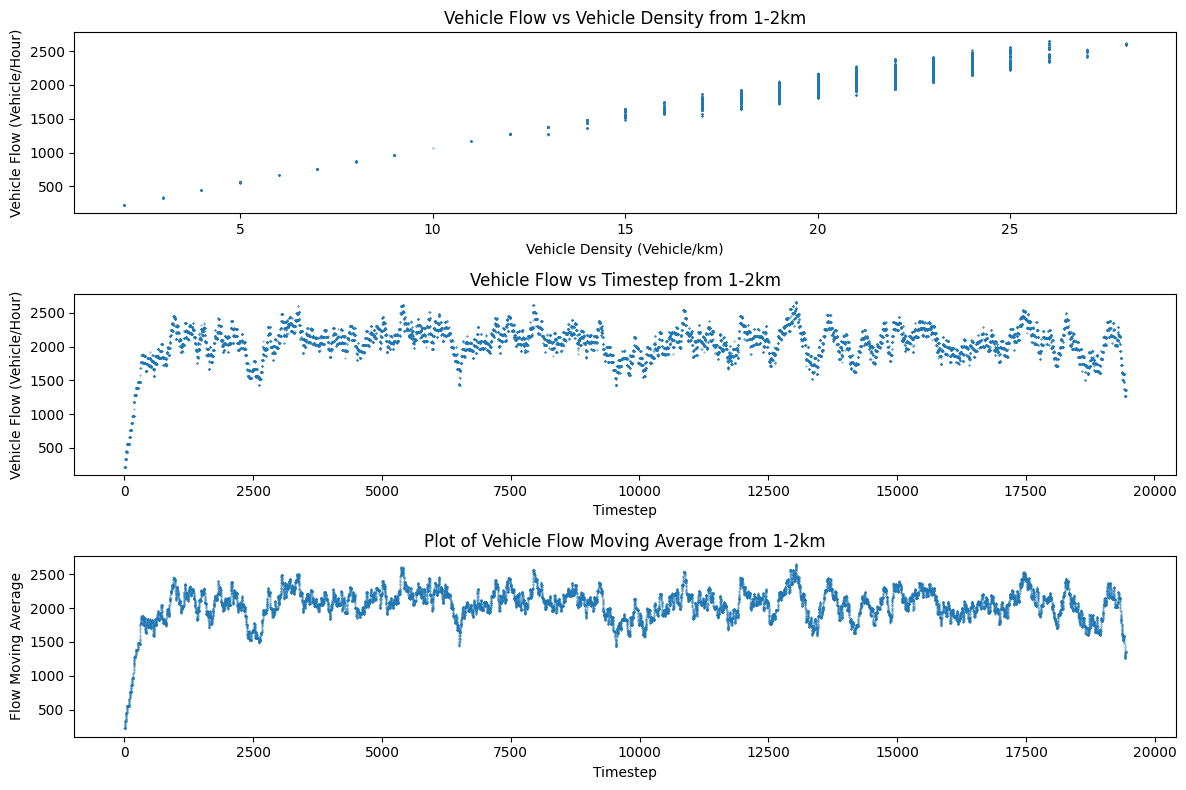

In [277]:
# Compute traffic flow moving average across 10 frame intervals
moving_average_flow_df = sorted_df['flow'].rolling(window=10).mean()
cleaned_df = moving_average_flow_df.dropna(axis=0)
moving_average_list = cleaned_df.tolist()

num_vehicles = sorted_df['num_vehicles'].values.tolist()
flow = sorted_df['flow'].values.tolist()

# Plotting Data
plt.figure(figsize=(12,8))

# Plotting Vehicle Flow vs Vehicle Density
plt.subplot(3,1,1)
plt.scatter(num_vehicles, flow, 0.1)
plt.xlabel('Vehicle Density (Vehicle/km)')
plt.ylabel('Vehicle Flow (Vehicle/Hour)')
plt.title('Vehicle Flow vs Vehicle Density from 1-2km')

# Plotting Vehicle Flow vs Timestep
plt.subplot(3,1,2)
plt.scatter(range(len(flow)), flow, 0.1)
plt.xlabel('Timestep')
plt.ylabel('Vehicle Flow (Vehicle/Hour)')
plt.title('Vehicle Flow vs Timestep from 1-2km')

# Plotting Vehicle Flow Moving Average vs Timestep
plt.subplot(3,1,3)
plt.scatter(range(len(moving_average_list)), moving_average_list, 0.1)  # Adding markers for each data point
plt.xlabel('Timestep')
plt.ylabel('Flow Moving Average')
plt.title('Plot of Vehicle Flow Moving Average from 1-2km')

plt.tight_layout()
plt.show()